<a href="https://colab.research.google.com/github/AkiraMarques/Desafio-DIO-Treinamento-de-Redes-Neurais-com-Transfer-Learning/blob/main/desafio_2_formacao_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transferência de aprendizagem**
O aprendizado de transferência consiste em pegar recursos aprendidos em um problema e aproveitá-los em um problema novo e semelhante.
Neste exemplo irei aproveitar o modelo MobileNetV2.
O método geralmente é feito para tarefas em que seu conjunto de dados tem poucos dados para treinar um modelo do zero.
Foram testados outros modelos, que podem ser observados aqui.
Devido ao desempenho e limitação de hardware optei pelo modelo MobileNetV2, pois nas mil imagens testadas obtive uma acurácia acima de 95%.

# Importação das bibliotecas

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
#tf._version_

## **Carregamento das imagens**
* Para este estudo, serão utilizados 4mil imagens de forma aleatória e balanceada entre gatos e cães para o treinamento do modelo.

* Para o Teste(validação) foram separadas mil imagens dividas entre gatos e cães.

* As imagens foram selecionadas à partir Kaggle Cats and Dogs.

In [ ]:
#Conectando ao google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* O trecho acima foi utilizado somente para buscar o arquivo que encontrava-se em formato zip no google drive
* já o trecho abaixo foi utilizado para descompactar o arquivo

In [ ]:
#Realizando a extração do arquivo zip.
path = '/content/drive/MyDrive/Colab Notebooks/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

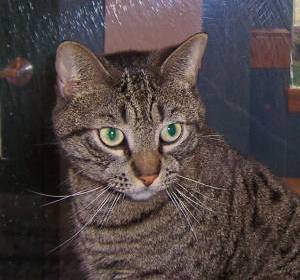

In [ ]:
#Visualizando uma imagem da pasta de treinamento cat.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.1.jpg')

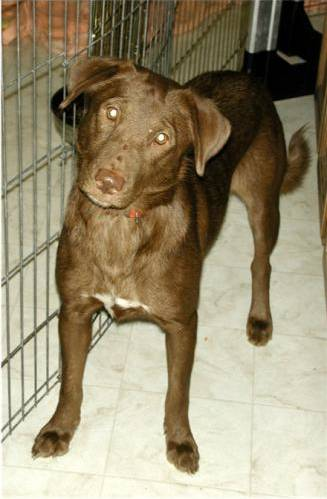

In [ ]:
#Visualizando uma imagem da pasta de treinamento dog.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.1.jpg')

# Base de dados de treinamento e teste

Como usar o aumento de dados aleatórios

* Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir diversidade de amostra artificialmente aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como inversão horizontal aleatória ou pequenas rotações aleatórias e zoom nas imagens. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento enquanto diminui o overfitting.
* Precisamos também normalizar e redimensionar todas as imagens para o mesmo padrão, para isso irei utilizar o método ImageDataGenerator conforme abaixo.

In [ ]:
#Realizando o redimensionamento e a normalização no conjunto de treinamento.
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog/training_set',
                                                              target_size = (128, 128),
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              shuffle = True)

Found 4000 images belonging to 2 classes.


* Foram encontradas 4000 imagens e 2 classes(cat e dog).
* Visualizando o comportamento das imagens apenas para uma melhor compreensão das alterações realizadas

Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


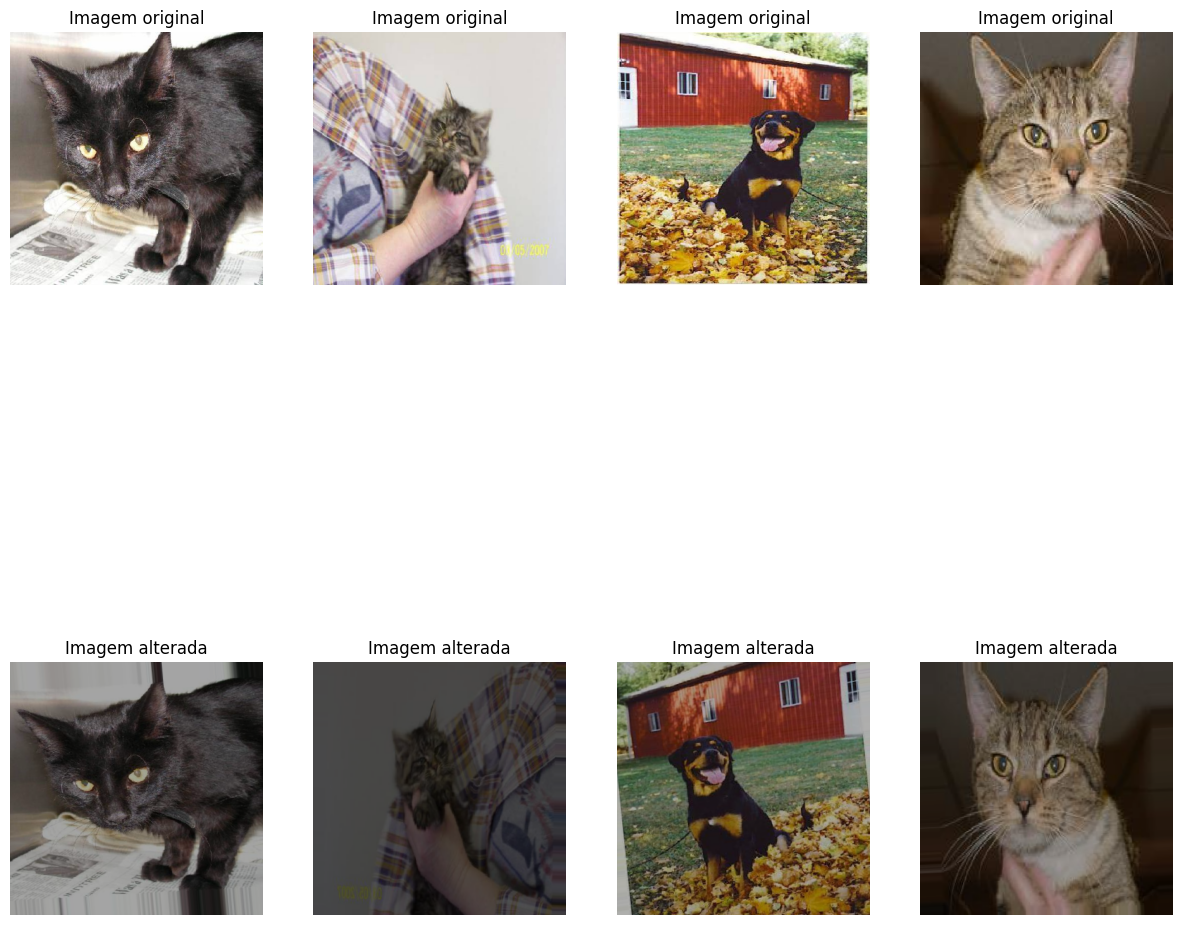

In [ ]:
#Altareando as imagens.
datagen = ImageDataGenerator(
    rotation_range=7, #Rotação
    zoom_range=0.2, #Aplicando 20% de zoom
    horizontal_flip=True, #horizontal flip
    brightness_range=[0.2,1.2] #brilho
)

#Imagem sem alteração
datanorm = ImageDataGenerator()

#Conjunto com alterações
treino_alterado = datagen.flow_from_directory(
    '/content/cat_dog/training_set',
    target_size=(400, 400), #padronizando todas as imagens
    color_mode="rgb", #imagem colorida
    batch_size=1, #numero de imagens extraída por batch
    class_mode="binary", #classes
    seed=2020 #para que os resultados sejam reproduzidos
)

#conjunto sem sofrer alterações
treino_normal = datanorm.flow_from_directory(
    '/content/cat_dog/training_set',
    target_size=(400, 400),
    color_mode="rgb",
    batch_size=1,
    class_mode="binary",
    seed=2020
)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

#Plotando 5 imagens
for i in range(4):

  #convertendo a imagem para inteiro
  image = next(treino_alterado)[0].astype('uint8')
  image2 = next(treino_normal)[0].astype('uint8')

  #alterando o fomarto (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)

  #plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

* Podemos ver que além do redimensionamento de todas as imagens para 128 x 128, foram criadas novas imagens de forma invertida, com uma leve rotação, outras com 20% de zoom e com menos brilho, etc...

In [ ]:
#Realizando o redimensionamento e a normalização no conjunto de teste.
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog/test_set',
                                                  target_size = (128, 128),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 1000 images belonging to 2 classes.


* Foram localizadas 1000 imagens e 2 classes para o conjunto de teste

# Rede neural pré-treinada

* Conforme mencionado, vamos utilizar o modelo 'MobileNetV2' que já foi treinado para outros fins, assim não precisaremos implementar do zero, o que seria impraticável devido ao poder computacional requirido da máquina e a quantidade de dados, certamente não seria obtido um resultado equivalente.
* A idéia é basicamente, utilizar todos os pesos das camadas do modelo que já foi treinado(know-how) e implementar apenas as camadas finais para o objetivo proposto, que nesse caso é saber identificar se o animal é um gato ou cachorro

In [ ]:
#Carregando o modelo base MobileNetV2
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                                input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#Informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [ ]:
#Visuzalizando a quantidade de camadas que o modelo possui.
len(modelo_base.layers)

154

In [ ]:
#Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

* O modelo possui 154 camadas que iremos reaproveitar, para isso foi utilizado o parametro False em layer.trainable para fixar os pesos das camadas.

# Camada densa personalizada

In [ ]:
#Acessando a última camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

* A última camada possui 1280 conexões para realizar a ligação com a nova camada, irei utilizar a metade dessas conexões.
* Dropout irá descartar 20% das conexões para próxima camada, isso reduz o overfitting.
* Ao final criamos uma camada densa de 2 conexões para classificação (gato, cachorro).

In [ ]:
(1280 + 2) /2

641.0

In [ ]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

# Construção e treinamento da rede neural

In [ ]:
#Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [ ]:
#Visualizando as informações das camadas.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
#Adicionamos as 6 camadas finais ao modelo.
len(network.layers)

160

In [ ]:
#Compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
#Realizando o treinamento com 5 epocas.
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
32/32 [==============================] - 23s 522ms/step - loss: 0.3221 - accuracy: 0.8838
Epoch 2/5
32/32 [==============================] - 18s 554ms/step - loss: 0.1093 - accuracy: 0.9580
Epoch 3/5
32/32 [==============================] - 18s 550ms/step - loss: 0.0982 - accuracy: 0.9580
Epoch 4/5
32/32 [==============================] - 18s 554ms/step - loss: 0.0800 - accuracy: 0.9693
Epoch 5/5
32/32 [==============================] - 18s 554ms/step - loss: 0.0770 - accuracy: 0.9682


# Avaliação a rede neural com o conjunto de teste

In [ ]:
#Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

1000/1000 [==============================] - 6s 5ms/step - loss: 0.0831 - accuracy: 0.9690


[0.08308658748865128, 0.968999981880188]

In [ ]:
#Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

1000/1000 [==============================] - 5s 5ms/step


array([[9.0194607e-01, 9.8053932e-02],
       [9.9459767e-01, 5.4022549e-03],
       [9.9999535e-01, 4.6658711e-06],
       ...,
       [3.2692900e-01, 6.7307103e-01],
       [2.4343420e-02, 9.7565651e-01],
       [9.4717547e-07, 9.9999905e-01]], dtype=float32)

In [ ]:
#previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] #10 primeiros registros.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#Classificação real do conjunto de teste
dataset_teste.classes[:10] #10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
#Usando a função de acurácia do sklearn apenas para comparar se os resultados estão corretos.
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.969

In [ ]:
network.evaluate(dataset_teste)

1000/1000 [==============================] - 5s 5ms/step - loss: 0.0831 - accuracy: 0.9690


[0.08308658748865128, 0.968999981880188]

* Conforme o resultado, tivemos 96,9% de acurácia no conjunto de teste.
* Vamos plotar o gráfico da matriz de confusão

In [ ]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

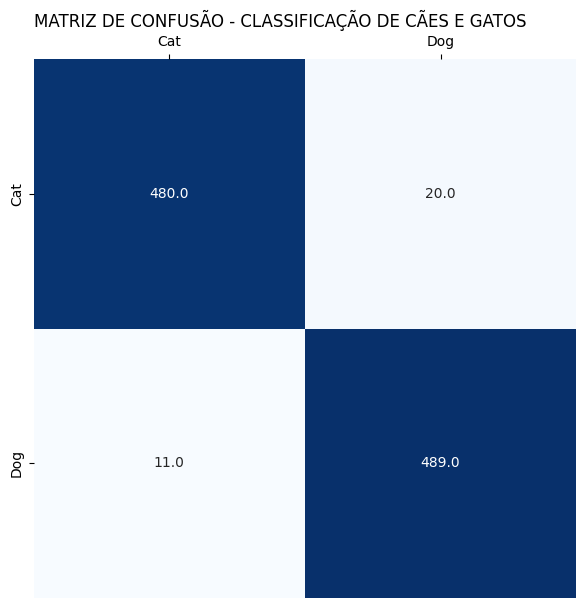

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
#figura
fig, ax = plt.subplots(figsize=(7, 7))
#plot heatmap
sns.heatmap(cm, cmap="Blues", annot=True, fmt=".1f", cbar=False)
#xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

#yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
#axis labels
plt.xlabel('')
plt.ylabel('')
#title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc='left')
plt.show()

* Pela matriz podemos ver que o modelo acertou 480 gatos dos 500 e errou 20.
* O modelo acertou 489 Cães e classificou 11 de forma equivocada.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       500
           1       0.96      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



* O modelo teve um resultado bem satisfatório para detectar ambas imagens.

# Salvar e carregar a rede neural

In [ ]:
#Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
#Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-31-383247b1bdb0>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')


In [ ]:
#Visualizando o arquivo.json
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint

In [ ]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
#Conferindo as informações das camadas
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

* Com o modelo salvo podemos criar uma applicação para consumir o modelo e classificar imagens de cães e gatos.

# Classificação de uma única imagem
* Vamos testar em uma única imagem para simular uma aplicação.

In [ ]:
#Carregando uma imagem
imagem = cv2.imread('/content/cat_dog/test_set/cat/cat.3506.jpg')

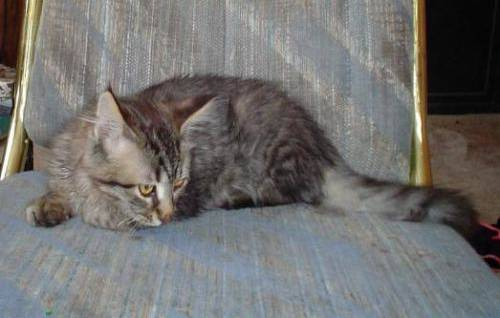

In [ ]:
cv2_imshow(imagem)

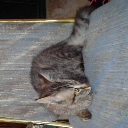

In [ ]:
#Alterando para o tamanho padrão e rotacionando a imagem para dificultar a classificação.
imagem = cv2.resize(imagem, (128, 128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [ ]:
#Normalizando a imagem.
imagem = imagem / 255
imagem

array([[[0.03921569, 0.03921569, 0.03921569],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03137255, 0.03137255, 0.03137255],
        ...,
        [0.47843137, 0.43921569, 0.35686275],
        [0.48235294, 0.43137255, 0.34509804],
        [0.48627451, 0.44313725, 0.34509804]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.45882353, 0.41960784, 0.36470588],
        [0.45882353, 0.41960784, 0.34901961],
        [0.4627451 , 0.41568627, 0.34509804]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.49411765, 0.43529412, 0.38039216],
        [0.4627451 , 0.4       , 0.33333333],
        [0.47843137, 0.41568627, 0.34901961]],

       ...,

       [[0.05490196, 0.12941176, 0.23529412],
        [0.04313725, 0.11764706, 0.22352941],
        [0.04313725, 0

In [ ]:
#Conferindo o formato.
imagem.shape

(128, 128, 3)

In [ ]:
#Necessário realizar o reshape para que o modelo entenda o formato.
imagem = imagem.reshape(1,128,128,3)

In [ ]:
#Realizando a previsão.
previsao = network_loaded(imagem)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9623549 , 0.03764516]], dtype=float32)>

In [ ]:
previsao = np.argmax(previsao)
previsao

0

In [ ]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
if previsao == 0:
  print('O modelo identificou que o animal é um: Gato')
else:
  print('O modelo identificou que o animal é um: Cão')

O modelo identificou que o animal é um: Gato
